In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import sys
import scipy.stats
from scipy.stats.mstats import gmean
import scipy.stats as stats
import math
import matplotlib as mpl
from sklearn.cluster import KMeans
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"



In [23]:
#CellType:
Cell='T8'
Dir= '{}'.format(Cell)

RawCountF= '{}/RAOANorm_{}.count'.format(Cell,Cell)   #read PeakCount 
RawCountDF=pd.read_csv(RawCountF,sep='\t',index_col=0)
RawBedF= '{}/RAOANorm_{}.merged.peak.list'.format(Cell,Cell)  #read PeakBed 
RawBedDF=pd.read_table(RawBedF,sep='\t',header=None)
RawBedDF.index=RawBedDF[3]
RawBedDF=RawBedDF[RawBedDF[0]!='chrY']
RawCountDF=RawCountDF.loc[RawBedDF.index]
RawBedDF.to_csv('{}/RAOAHC_{}.removeY.bed'.format(Cell,Cell),sep='\t',header=False,index=False)
RawCountDF.to_csv('{}/RAOAHC_{}.removeY.txt'.format(Cell,Cell),sep='\t')


BedF= '{}/RAOAHC_{}.removeY.bed'.format(Cell,Cell)  #read PeakBed 
BedDF=pd.read_table(BedF,sep='\t',header=None)
BedDF.index=BedDF[3]
CountF= '{}/RAOAHC_{}.removeY.txt'.format(Cell,Cell)   #read PeakCount 
CountDF=pd.read_csv(CountF,sep='\t',index_col=0)


# 1.Normalization

In [24]:
Cell='T8'
CountF= '{}/RAOAHC_{}.removeY.txt'.format(Cell,Cell)   #read PeakCount 
CountDF=pd.read_csv(CountF,sep='\t',index_col=0)

def Log2(L):return np.array([math.log(i+1.0,2) for i in L])
def QNormCount(DF):
    DFrank=DF.stack().groupby(DF.rank(method='first').stack().astype(int)).mean()
    DF=DF.rank(method='min').stack().astype(int).map(DFrank).unstack()
    DFlog2=DF.apply(Log2)

    DF.to_csv('{}/ATACseq_QNorm_{}.txt'.format(Cell,Cell),sep='\t')
    DFlog2.to_csv('{}/ATACseq_QNorm_{}.log2.txt'.format(Cell,Cell),sep='\t')

QNormCount(CountDF)

# 2.Data Feature

In [25]:
Cell='Bcells'
outDir=os.path.join('{}/DataFeature'.format(Cell))
if not os.path.exists(outDir):
    os.mkdir(outDir)

F='{}/ATACseq_QNorm_{}.log2.txt'.format(Cell,Cell)
QNormDF=pd.read_table(F,sep='\t',index_col=0)
#QNormDF=QNormDF[QNormDF.apply(np.mean,axis=1)>=3]   #filter peak（average>=3）
    
ColorF='{}/ColorDF_{}.txt'.format(Cell,Cell)   #set samples color and label
ColorDF=pd.read_table(ColorF,sep='\t',index_col=0)
LabelF='{}/LabelDF_{}.txt'.format(Cell,Cell)
LabelDF=pd.read_table(LabelF,sep='\t',index_col=0)


Normalized data distribution:


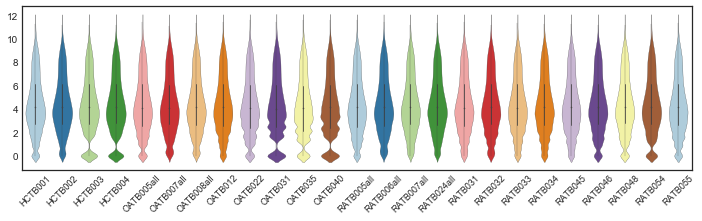

Heatmap of samples pearson correlation:


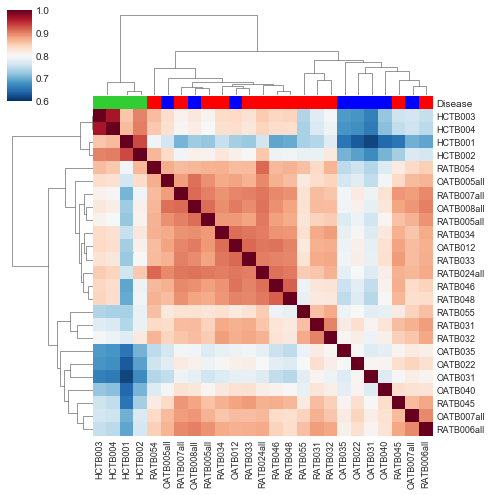

PCA of smaples:


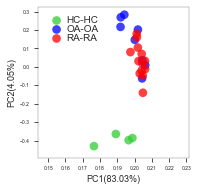

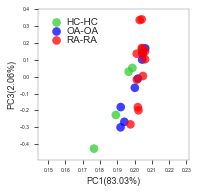

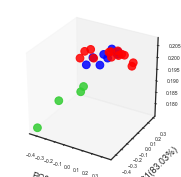

In [26]:
#Figure: normalized data distribution
print ('Normalized data distribution:')
fig=plt.figure(figsize=(12,3))
sns_plot = sns.violinplot(data=QNormDF,linewidth=0.25,palette = 'Paired', width=0.75)
plt.xticks(rotation=45,fontsize=9)
outfig=outDir+'/{}_QNormLog2_DataDistribution'.format(Cell)+'.pdf'
plt.savefig(outfig)
plt.show()

print ('Heatmap of samples pearson correlation:')
RNAT=np.array(QNormDF).T
RNAcorrcoef=np.corrcoef(RNAT)   #np.corrcoef: Pearson product-moment correlation coefficients
RNAcorrcoefDF=pd.DataFrame(RNAcorrcoef,index=list(QNormDF),columns=list(QNormDF))
fig=sns.clustermap(RNAcorrcoefDF,method='average',metric='correlation',cmap='RdBu_r',vmax=1,vmin=0.6,figsize=(7,7),col_colors=ColorDF,row_cluster=True,col_cluster=True,yticklabels=list(QNormDF),linecolor=None)
plt.setp(fig.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)
plt.setp(fig.ax_heatmap.get_xticklabels(), rotation=90, fontsize=9)
plt.savefig(outDir+'/{}_QNormLog2_SamplesCorr.pdf'.format(Cell))
plt.show()

print ('PCA of smaples:')
COLOR={'RA':'red','OA':'blue','HC':'limegreen'}
SHAPE={'RA':'o','OA':'o','HC':'o'}
def SamplesPCA(inDFP,outfigPrex,labelDF=LabelDF,colorhue='Disease',colorDict=COLOR,markerhue='Disease',markerDict=SHAPE):

    pca=PCA(n_components=3)
    pca.fit(inDFP)
    pca_ratio=pca.explained_variance_ratio_
    newDatal=pd.DataFrame(np.transpose(pca.components_),index=inDFP.columns)
    labelDF=labelDF.loc[newDatal.index]          
    newDatal['Color']=labelDF[colorhue]
    if markerhue:
        newDatal['Marker']=labelDF[markerhue]

    def pca_2D(a,b,Txt):

        plt.style.use('seaborn-white')
        fig1=plt.figure(figsize=(3,3))
        ax1=fig1.add_axes([0.2,0.2,0.7,0.7])
        ax1.spines['bottom'].set_linewidth(0.25)
        ax1.spines['left'].set_linewidth(0.25)
        ax1.spines['right'].set_linewidth(0.25)
        ax1.spines['top'].set_linewidth(0.25)
        ax1.set_xlabel('PC{}({:.2f}%)'.format(a,pca_ratio[a-1]*100),fontsize=9)
        ax1.set_ylabel('PC{}({:.2f}%)'.format(b,pca_ratio[b-1]*100),fontsize=9)
        ax1.tick_params(axis='both',length=4,labelsize=5,direction='out')
        for i in newDatal.groupby(newDatal['Color']):
            subDF=i[1]
            cl=list(subDF['Color'])[0]
            #print 'c1:',cl
            C=colorDict[cl]
            if markerhue:
                for j in subDF.groupby(subDF['Marker']):
                    
                    ssubDF=j[1]
                    
                    #ml=ssubDF['Marker'][1]
                    ml=j[0]
                    M=markerDict[ml]
                    ax1.scatter(ssubDF[a-1],ssubDF[b-1],s=75,c=C,marker=M,alpha=0.75,edgecolors='none',label=cl+'-'+ml)
            else:
                M='o'
                ax1.scatter(subDF[a-1],subDF[b-1],s=75,c=C,marker=M,alpha=0.65,edgecolors='none',label=cl)
        ax1.legend(fontsize=10,markerscale=1,ncol=1,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0)    
        ax1.tick_params(axis='both',length=4,labelsize=5,direction='out')
        if Txt:
            outfig='{}.2D.{}-{}.Txt.pdf'.format(outfigPrex,str(a),str(b))
            for i in newDatal.index:
                ax1.text(newDatal[a-1][i],newDatal[b-1][i],i.split('T')[0],fontsize=5)
            plt.savefig(outfig)
        else:
            outfig='{}.2D.{}-{}.pdf'.format(outfigPrex,str(a),str(b))    
            plt.savefig(outfig)
        
    def pca_3D(a,b,c,Txt):
        plt.style.use('seaborn-white')
        ax1=plt.subplot(111,projection='3d')
        ax1.spines['bottom'].set_linewidth(0.25)
        ax1.spines['left'].set_linewidth(0.25)        
        ax1.set_xlabel('PC{}({:.2f}%)'.format(a,pca_ratio[a-1]*100),fontsize=9)
        ax1.set_ylabel('PC{}({:.2f}%)'.format(b,pca_ratio[b-1]*100),fontsize=9)
        ax1.set_ylabel('PC{}({:.2f}%)'.format(c,pca_ratio[c-1]*100),fontsize=9)  
        ax1.grid(False)               
        for i in newDatal.groupby(newDatal['Color']):
            subDF=i[1]
            cl=subDF['Color'][1]
            C=colorDict[cl]
            if markerhue:
                for j in subDF.groupby(subDF['Marker']):
                    ssubDF=j[1]
                    #ml=ssubDF['Marker'][1]
                    ml=j[0]
                    M=markerDict[ml]
                    ax1.scatter(ssubDF[a-1],ssubDF[b-1],ssubDF[c-1],s=60,c=C,marker=M,alpha=0.85,edgecolors=C,label=cl+'-'+ml)
            else:
                M='o'
                ax1.scatter(subDF[a-1],subDF[b-1],subDF[c-1],s=60,c=C,marker=M,alpha=0.55,edgecolors=C,label=cl)
        #ax1.legend(fontsize=10,markerscale=1,ncol=1,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0,loc='South')    
        ax1.tick_params(axis='both',length=4,labelsize=5,direction='out') 
        if Txt:
            outfig='{}.3D.{}-{}-{}.Txt.pdf'.format(outfigPrex,str(a),str(b),str(c))
            for i in newDatal.index:
                ax1.text(newDatal[a-1][i],newDatal[b-1][i],newDatal[c-1][i],i.split('T')[0],fontsize=5)
            plt.savefig(outfig)
        else:
            outfig='{}.3D.{}-{}-{}.pdf'.format(outfigPrex,str(a),str(b),str(c))    
            plt.savefig(outfig) 
 


    pca_2D(1,2,False)
    pca_2D(1,3,False)
    pca_2D(2,3,False)
    pca_3D(1,2,3,False)
    pca_3D(1,3,2,False)
    pca_3D(2,3,1,False)
    pca_3D(2,1,3,False)
    pca_3D(3,1,2,False)
    pca_3D(3,2,1,False)

    

#4.Run PCA
SamplesPCA(QNormDF,outDir+'/{}'.format(Cell))
plt.show()

# 3.Diff peaks filter_1

In [27]:
#CellType:
Cell='Bcells'

outDir=os.path.join('{}/DiffPeaks'.format(Cell))
if not os.path.exists(outDir):
    os.mkdir(outDir)

F='{}/ATACseq_QNorm_{}.log2.txt'.format(Cell,Cell)
QNormDF=pd.read_table(F,sep='\t',index_col=0)
QNormDF=QNormDF[QNormDF.apply(np.mean,axis=1)>=3]   #filter peak（average>=3）

RAs=[i for i in list(QNormDF) if 'RA' in i]
OAs=[i for i in list(QNormDF) if 'OA' in i]
HCs=[i for i in list(QNormDF) if 'HC' in i]

In [28]:
#Def DiffPeaks TwoTwoCompare(RAvsOA , RAvsHC , OAvsHC):
def fdr_BH(p_vals):
    
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1
    
    return fdr

def TwoTwoCompare_DiffPeak(DF,ASamples,BSamples,Aname,Bname,log2fc,pval,fdr):
    
    ACount=DF[ASamples]
    BCount=DF[BSamples]
    AvsB_FD_up=(ACount.apply(np.mean,axis=1)-BCount.apply(np.mean,axis=1))>log2fc
    AvsB_FD_down=(BCount.apply(np.mean,axis=1)-ACount.apply(np.mean,axis=1))>log2fc
    AvsB_PVAL=(pd.Series(scipy.stats.ttest_ind(ACount,BCount,axis=1)[1],index=ACount.index))<pval
    AvsB_PVAL1=pd.Series(scipy.stats.ttest_ind(ACount,BCount,axis=1)[1],index=ACount.index)
    AvsB_QVVAL=(pd.Series(fdr_BH(AvsB_PVAL1),index=ACount.index))<fdr
    FilterDF_up=DF[AvsB_FD_up & AvsB_PVAL & AvsB_QVVAL]
    FilterDF_down=DF[AvsB_FD_down & AvsB_PVAL & AvsB_QVVAL]
    
    print ('log2fc_{} peaksN:'.format(log2fc))
    print ('    {}_vs_{}_up: {}'.format(Aname,Bname,len(FilterDF_up)))
    print ('    {}_vs_{}_up: {}'.format(Bname,Aname,len(FilterDF_down)))
    
    with open(outDir+'/{}vs{}_DiffPeaksNum.txt'.format(Aname,Bname),'a+')as f:
        f.write('%sup_logF%s\t%s\t%sup_logF%s\t%s\n'%(Aname,log2fc,len(FilterDF_up),Bname,log2fc,len(FilterDF_down)))

        
        

In [29]:
#FD=[1.5,2,2.5,4]
log2FD=[2,1.3,1,0.58]

print ('RAvsOA:')
for i in log2FD:
    TwoTwoCompare_DiffPeak(QNormDF,RAs,OAs,'RA','OA',i,0.001,0.1)
print ( )

print ('RAvsHC:')
for i in log2FD:
    TwoTwoCompare_DiffPeak(QNormDF,RAs,HCs,'RA','HC',i,0.001,0.1)
print ( )

print ('OAvsHC:')
for i in log2FD:
    TwoTwoCompare_DiffPeak(QNormDF,OAs,HCs,'OA','HC',i,0.001,0.1)


RAvsOA:
log2fc_2 peaksN:
    RA_vs_OA_up: 0
    OA_vs_RA_up: 0
log2fc_1.3 peaksN:
    RA_vs_OA_up: 1
    OA_vs_RA_up: 0
log2fc_1 peaksN:
    RA_vs_OA_up: 1
    OA_vs_RA_up: 0
log2fc_0.58 peaksN:
    RA_vs_OA_up: 1
    OA_vs_RA_up: 0

RAvsHC:
log2fc_2 peaksN:
    RA_vs_HC_up: 1699
    HC_vs_RA_up: 575
log2fc_1.3 peaksN:
    RA_vs_HC_up: 4115
    HC_vs_RA_up: 2015
log2fc_1 peaksN:
    RA_vs_HC_up: 5444
    HC_vs_RA_up: 2931
log2fc_0.58 peaksN:
    RA_vs_HC_up: 6813
    HC_vs_RA_up: 4180

OAvsHC:
log2fc_2 peaksN:
    OA_vs_HC_up: 1429
    HC_vs_OA_up: 531
log2fc_1.3 peaksN:
    OA_vs_HC_up: 2633
    HC_vs_OA_up: 1091
log2fc_1 peaksN:
    OA_vs_HC_up: 3213
    HC_vs_OA_up: 1528
log2fc_0.58 peaksN:
    OA_vs_HC_up: 3704
    HC_vs_OA_up: 2100


In [44]:
#FD=[1.5,2,2.5,4]
#log2FD=[2,1.3,1,0.58]

#for i in log2FD:
#    TwoTwoCompare_DiffPeak(QNormDF,RAs,OAs,'RA','OA',i,0.05,0.1)

# 4.Diff peaks filter_2（Kmeans）

In [30]:
#mean3_fc2_log2fc1_p0.001_fdr0.05
def fdr_BH(p_vals):   
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1 
    return fdr

def TwoTwoCompare_DiffPeak_Out(DF,Dir,ASamples,BSamples,Aname,Bname,log2fc,pval,fdr):

    ACount=DF[ASamples]
    BCount=DF[BSamples]
    AvsB_FD_up=(ACount.apply(np.mean,axis=1)-BCount.apply(np.mean,axis=1))>log2fc
    AvsB_FD_down=(BCount.apply(np.mean,axis=1)-ACount.apply(np.mean,axis=1))>log2fc
    AvsB_PVAL=(pd.Series(scipy.stats.ttest_ind(ACount,BCount,axis=1)[1],index=ACount.index))<pval
    AvsB_PVAL1=pd.Series(scipy.stats.ttest_ind(ACount,BCount,axis=1)[1],index=ACount.index)
    AvsB_QVVAL=(pd.Series(fdr_BH(AvsB_PVAL1),index=ACount.index))<fdr
    FilterDF_up=DF[AvsB_FD_up & AvsB_PVAL & AvsB_QVVAL]
    FilterDF_down=DF[AvsB_FD_down & AvsB_PVAL & AvsB_QVVAL]
    FilterBed_up=BedDF.loc[list(FilterDF_up.index)]
    FilterBed_down=BedDF.loc[list(FilterDF_down.index)]
    
    FilterDF_up.to_csv(Dir+'/{}_vs_{}_up.txt'.format(Aname,Bname),sep='\t')
    FilterDF_down.to_csv(Dir+'/{}_vs_{}_down.txt'.format(Aname,Bname),sep='\t')
    FilterBed_up.to_csv(Dir+'/{}_vs_{}_up.bed'.format(Aname,Bname),sep='\t',header=False,index=False)
    FilterBed_down.to_csv(Dir+'/{}_vs_{}_down.bed'.format(Aname,Bname),sep='\t',header=False,index=False)
    
    


In [32]:
Cell='Bcells'
F='{}/ATACseq_QNorm_{}.log2.txt'.format(Cell,Cell)
QNormDF=pd.read_table(F,sep='\t',index_col=0)
QNormDF=QNormDF[QNormDF.apply(np.mean,axis=1)>=3]   #filter peak（average>=3）
BedF= '{}/RAOAHC_{}.removeY.bed'.format(Cell,Cell)  #read PeakBed 
BedDF=pd.read_table(BedF,sep='\t',header=None)
BedDF.index=BedDF[3]

RAs=[i for i in list(QNormDF) if 'RA' in i]
OAs=[i for i in list(QNormDF) if 'OA' in i]
HCs=[i for i in list(QNormDF) if 'HC' in i]

outDir=os.path.join('{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05'.format(Cell))
if not os.path.exists(outDir):
    os.mkdir(outDir)
    
TwoTwoCompare_DiffPeak_Out(QNormDF,outDir,RAs,OAs,'RA','OA',1,0.001,0.1)
TwoTwoCompare_DiffPeak_Out(QNormDF,outDir,RAs,HCs,'RA','HC',1,0.001,0.1)
TwoTwoCompare_DiffPeak_Out(QNormDF,outDir,OAs,HCs,'OA','HC',1,0.001,0.1)

#For B,T4 and T8 cells:

In [36]:
#Run Terminal !!!:
#1.cat 
#awk '{print $0}' *.txt > combine.txt
#2.remove duplicates
#awk '!x[$0]++' combine.txt > TwoTwoCompare_Merge.txt

Cell='T8'

F='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/TwoTwoCompare_Merge.txt'.format(Cell)
DiseaseSP_DF=pd.read_table(F,sep='\t',index_col=0)

BedF= '{}/RAOAHC.removeY.bed'.format(Cell)  #read PeakBed 
BedDF=pd.read_table(BedF,sep='\t',header=None)
BedDF.index=BedDF[3]
DiseaseSP_Bed=BedDF.loc[list(DiseaseSP_DF.index)]
DiseaseSP_Bed.to_csv('{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/TwoTwoCompare_Merge.bed'.format(Cell),sep='\t',header=False,index=False)

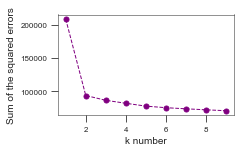

K-means Done !


In [37]:
#1.Z-score Normalzie DiseaseSP_DF:
Cell='T8'
outDir=os.path.join('{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/KmeansCluster'.format(Cell))
if not os.path.exists(outDir):
    os.mkdir(outDir)

DiseaseSP_F='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/TwoTwoCompare_Merge.txt'.format(Cell)
DiseaseSP_DF=pd.read_table(DiseaseSP_F,sep='\t',index_col=0)
DiseaseSP_DFz= DiseaseSP_DF.apply(scipy.stats.zscore,axis=1,result_type='broadcast')

#decide K:1.手肘法(误差平方法SSE);2.轮廓系数法
SSE = []  # 存放每次结果的误差平方和
for k in range(1,10):
    estimator = KMeans(n_clusters=k) 
    estimator.fit(DiseaseSP_DFz)
    SSE.append(estimator.inertia_)
X = range(1,10)
plt.style.use('seaborn-white')
fig=plt.figure(figsize=(3.5,2))
ax=fig.add_axes([0.2,0.2,0.7,0.7])
ax.set_ylabel('Sum of the squared errors',fontsize=10)
ax.set_xlabel('k number',fontsize=10)
ax.tick_params(axis='y',length=7,labelsize=8,direction='out')
ax.tick_params(axis='x',length=7,labelsize=8,direction='out')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
plt.plot(X,SSE,color='purple', marker='o', linestyle='dashed',linewidth=1, markersize=5)
fig.savefig(outDir+'/Kvalue_SSE.pdf')
#print '误差平方和：'
plt.show()

2.#根据最佳K值进行KMeans聚类 (Kmeans聚类用的ZscoreNorm后的DF!!!)
def KMean_Cluster(DF,outDirPrefix,k):
    #print 'Do KMean Cluster, k={}'.format(k)
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(DF)
    Kcluster=pd.DataFrame(kmeans.labels_,index=list(DF.index),columns=['Cluster'])
    Kcluster.to_csv(outDir+'/TwoTwoCompareMerge_zscore_k{}.txt'.format(k),sep='\t')
    #return Kcluster
KMean_Cluster(DiseaseSP_DFz,outDir,2)
KMean_Cluster(DiseaseSP_DFz,outDir,3)

print ('K-means Done !')

In [38]:
k='2'
Cell='T8'
DiseaseSP_F='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/TwoTwoCompare_Merge.txt'.format(Cell)
DiseaseSP_DF=pd.read_table(DiseaseSP_F,sep='\t',index_col=0)
RAs=[i for i in list(DiseaseSP_DF) if 'RA' in i]
OAs=[i for i in list(DiseaseSP_DF) if 'OA' in i]
HCs=[i for i in list(DiseaseSP_DF) if 'HC' in i]

BedF= '{}/RAOAHC.removeY.bed'.format(Cell)  #read PeakBed 
BedDF=pd.read_table(BedF,sep='\t',header=None)
BedDF.index=BedDF[3]


def PlotKmeanCluster_K2(k):
    kmeansDir=os.path.join('{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/KmeansCluster/kvalue_k{}/'.format(Cell,k))
    if not os.path.exists(kmeansDir):
        os.mkdir(kmeansDir)

    
    KClusterF='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/KmeansCluster/TwoTwoCompareMerge_zscore_k{}.txt'.format(Cell,k)
    KCluster=pd.read_table(KClusterF,sep='\t',index_col=0)
    
    k1=KCluster[KCluster['Cluster']==0]
    k2=KCluster[KCluster['Cluster']==1]
    k1DF=DiseaseSP_DF.loc[k1.index]
    k2DF=DiseaseSP_DF.loc[k2.index]
    k1Bed=BedDF.loc[k1DF.index]
    k2Bed=BedDF.loc[k2DF.index]
    
    if (k1DF.iloc[:,0:1].mean(axis=0)[0]) > (k2DF.iloc[:,0:1].mean(axis=0)[0]):
        KclusterDF_c1=k1DF.copy()
        KclusterDF_c2=k2DF.copy()
    else:
        KclusterDF_c1=k2DF.copy()
        KclusterDF_c2=k1DF.copy()
        
    KclusterBed_c1=BedDF.loc[KclusterDF_c1.index]
    KclusterBed_c2=BedDF.loc[KclusterDF_c2.index]
    KclusterBed_c1.to_csv(kmeansDir+'KmeansCluster_c1.bed',sep='\t',header=False,index=False)
    KclusterBed_c2.to_csv(kmeansDir+'KmeansCluster_c2.bed',sep='\t',header=False,index=False)
    KclusterDF_c1.to_csv(kmeansDir+'KmeansCluster_c1.txt',sep='\t')
    KclusterDF_c2.to_csv(kmeansDir+'KmeansCluster_c2.txt',sep='\t')
    KclusterDF_c1c2=pd.concat([KclusterDF_c1,KclusterDF_c2],axis=0)
    KclusterDF_c1c2.to_csv(kmeansDir+'KmeansCluster_all.txt',sep='\t')
    KclusterBed_c1c2=BedDF.loc[KclusterDF_c1c2.index]
    KclusterBed_c1c2.to_csv(kmeansDir+'KmeansCluster_all.bed',sep='\t',header=False,index=False)
    
    def DFmean(inputDF,C):
        Df=DiseaseSP_DF.loc[inputDF.index]
        hc=Df[HCs]
        oa=Df[OAs]
        ra=Df[RAs]
        hcmean=hc.mean(axis=1)
        hcmeanDF = hcmean.to_frame()
        hcmeanDF.rename(columns={0:'HC'}, inplace = True)
        oamean=oa.mean(axis=1)
        oameanDF = oamean.to_frame()
        oameanDF.rename(columns={0:'OA'}, inplace = True)
        ramean=ra.mean(axis=1)
        rameanDF = ramean.to_frame()
        rameanDF.rename(columns={0:'RA'}, inplace = True)
        MergeM = pd.concat([hcmeanDF,oameanDF,rameanDF],axis=1)
        MergeM.to_csv(kmeansDir+'KmeansCluster_{}.average.txt'.format(C),sep='\t')
        #Boxplot
        plt.style.use('seaborn-white')
        fig=plt.figure(figsize=(1.5,2))
        ax=fig.add_axes([0.2,0.2,0.75,0.75])
        #sns.violinplot(data=AA,ax=ax1,palette=(['steelblue','gold','orangered']))
        sns.boxplot(data=MergeM,ax=ax,palette=(['steelblue','gold','orangered']),whis=0.5,fliersize=0.5,width=0.7,showfliers=False,medianprops={'linewidth':0.5},whiskerprops={'linewidth':0.5},boxprops={'linewidth':0.5},capprops={'linewidth':0.5})
        ax.tick_params(labelsize=8,width=0.5,direction='out')
        #ax.set_ylim([0,10])
        ax.spines['bottom'].set_linewidth(0.25)
        ax.spines['left'].set_linewidth(0.25)
        ax.spines['right'].set_linewidth(0.25)
        ax.spines['top'].set_linewidth(0.25)
        fig.savefig(kmeansDir+'KmeansCluster_{}_average.boxplot.pdf'.format(C))
        plt.show()
    DFmean(KclusterDF_c1,'c1')
    DFmean(KclusterDF_c2,'c2')
    
    #zcore，plot heatmap:
    KclusterDFall_Z=KclusterDF_c1c2.apply(scipy.stats.zscore,axis=1,result_type='broadcast')
    KclusterDFc1_Z=KclusterDF_c1.apply(scipy.stats.zscore,axis=1,result_type='broadcast')
    KclusterDFc2_Z=KclusterDF_c2.apply(scipy.stats.zscore,axis=1,result_type='broadcast')

    fig1=sns.clustermap(KclusterDFall_Z,figsize=(4,5),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig1.savefig(kmeansDir+'KmeansCluster_all.heatmap.png',dpi=200)
    plt.show() 
    plt.close('all')
    fig2=sns.clustermap(KclusterDFc1_Z,figsize=(4,0.0009*len(KclusterDFc1_Z)),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig2.savefig(kmeansDir+'KmeansCluster_c1.heatmap.png',dpi=500)
    plt.show() 
    plt.close('all')
    fig3=sns.clustermap(KclusterDFc2_Z,figsize=(4,0.0009*len(KclusterDFc2_Z)),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig3.savefig(kmeansDir+'KmeansCluster_c2.heatmap.png',dpi=500)
    plt.show()
    plt.close('all')
    
    HCz=KclusterDFall_Z[HCs]
    OAz=KclusterDFall_Z[OAs]
    RAz=KclusterDFall_Z[RAs]
    HCmean=HCz.mean(axis=1)
    HCmeanDF = HCmean.to_frame()
    HCmeanDF.rename(columns={0:'HC'}, inplace = True)
    OAmean=OAz.mean(axis=1)
    OAmeanDF = OAmean.to_frame()
    OAmeanDF.rename(columns={0:'OA'}, inplace = True)
    RAmean=RAz.mean(axis=1)
    RAmeanDF = RAmean.to_frame()
    RAmeanDF.rename(columns={0:'RA'}, inplace = True)
    KclusterDFall_Z_average = pd.concat([HCmeanDF,OAmeanDF,RAmeanDF],axis=1)
    
    fig4=sns.clustermap(KclusterDFall_Z_average,figsize=(1,6),center=0,vmin=-1,vmax=0.8,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig4.savefig(kmeansDir+'KmeansCluster_all.heatmap.average.pdf')
    plt.show() 
    plt.close('all')

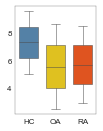

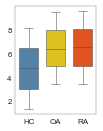

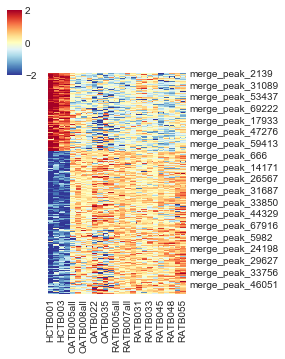

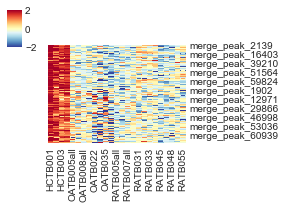

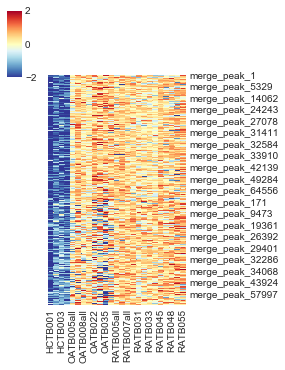

/Users/huangbeibei/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1165: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


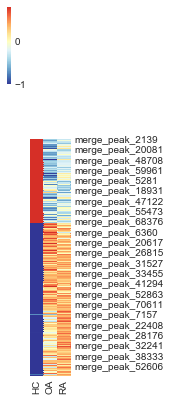

In [39]:
k='2'
PlotKmeanCluster_K2(k)

In [1]:
#For monocytes

In [ ]:
k='3'
Cell='Monocytes'
DiseaseSP_F='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/TwoTwoCompare_Merge.sortCol.txt'.format(Cell)
DiseaseSP_DF=pd.read_table(DiseaseSP_F,sep='\t',index_col=0)
RAs=[i for i in list(DiseaseSP_DF) if 'RA' in i]
OAs=[i for i in list(DiseaseSP_DF) if 'OA' in i]
HCs=[i for i in list(DiseaseSP_DF) if 'HC' in i]

BedF= '{}/RAOAHC.removeY.bed'.format(Cell)  #read PeakBed 
BedDF=pd.read_table(BedF,sep='\t',header=None)
BedDF.index=BedDF[3]

def PlotKmeanCluster_K3(k):
    kmeansDir=os.path.join('{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/KmeansCluster/kvalue_k{}/'.format(Cell,k))
    if not os.path.exists(kmeansDir):
        os.mkdir(kmeansDir)

    
    KClusterF='{}/DiffPeaks/mean3_fc2_p0.001_fdr0.05/KmeansCluster/TwoTwoCompareMerge_zscore_k{}.txt'.format(Cell,k)
    KCluster=pd.read_table(KClusterF,sep='\t',index_col=0)
    
    k1=KCluster[KCluster['Cluster']==0]
    k2=KCluster[KCluster['Cluster']==1]
    k3=KCluster[KCluster['Cluster']==2]
    k1DF=DiseaseSP_DF.loc[k1.index]
    k2DF=DiseaseSP_DF.loc[k2.index]
    k3DF=DiseaseSP_DF.loc[k3.index]
    k1Bed=BedDF.loc[k1DF.index]
    k2Bed=BedDF.loc[k2DF.index]
    k3Bed=BedDF.loc[k3DF.index]

    a1=k1DF.iloc[:,-2:-1].mean(axis=0)[0]
    a2=k2DF.iloc[:,-2:-1].mean(axis=0)[0]
    a3=k3DF.iloc[:,-2:-1].mean(axis=0)[0]
    if (a1 < a2) & (a2 < a3):
        KclusterDF_c1=k1DF.copy()
        KclusterDF_c2=k2DF.copy()
        KclusterDF_c3=k3DF.copy()
    elif (a1 < a3) & (a3 < a2):
        KclusterDF_c1=k1DF.copy()
        KclusterDF_c2=k3DF.copy()
        KclusterDF_c3=k2DF.copy()
    elif (a2 < a1) & (a1 < a3):
        KclusterDF_c1=k2DF.copy()
        KclusterDF_c2=k1DF.copy()
        KclusterDF_c3=k3DF.copy()
    elif (a2 < a3) & (a3 < a1):
        KclusterDF_c1=k2DF.copy()
        KclusterDF_c2=k3DF.copy()
        KclusterDF_c3=k1DF.copy()
    elif (a3 < a1) & (a1 < a2):
        KclusterDF_c1=k3DF.copy()
        KclusterDF_c2=k1DF.copy()
        KclusterDF_c3=k2DF.copy()
    elif (a3 < a2) & (a2 < a1):
        KclusterDF_c1=k3DF.copy()
        KclusterDF_c2=k2DF.copy()
        KclusterDF_c3=k1DF.copy()

    KclusterBed_c1=BedDF.loc[KclusterDF_c1.index]
    KclusterBed_c2=BedDF.loc[KclusterDF_c2.index]
    KclusterBed_c3=BedDF.loc[KclusterDF_c3.index]
    KclusterBed_c1.to_csv(kmeansDir+'KmeansCluster_c1.bed',sep='\t',header=False,index=False)
    KclusterBed_c2.to_csv(kmeansDir+'KmeansCluster_c2.bed',sep='\t',header=False,index=False)
    KclusterBed_c3.to_csv(kmeansDir+'KmeansCluster_c3.bed',sep='\t',header=False,index=False)
    KclusterDF_c1.to_csv(kmeansDir+'KmeansCluster_c1.txt',sep='\t')
    KclusterDF_c2.to_csv(kmeansDir+'KmeansCluster_c2.txt',sep='\t')
    KclusterDF_c3.to_csv(kmeansDir+'KmeansCluster_c3.txt',sep='\t')
    KclusterDF_c1c2c3=pd.concat([KclusterDF_c1,KclusterDF_c2,KclusterDF_c3],axis=0)
    KclusterDF_c1c2c3.to_csv(kmeansDir+'KmeansCluster_all.txt',sep='\t')
    KclusterBed_c1c2c3=BedDF.loc[KclusterDF_c1c2c3.index]
    KclusterBed_c1c2c3.to_csv(kmeansDir+'KmeansCluster_all.bed',sep='\t',header=False,index=False)

    def DFmean(inputDF,C):
        Df=DiseaseSP_DF.loc[inputDF.index]
        hc=Df[HCs]
        oa=Df[OAs]
        ra=Df[RAs]
        hcmean=hc.mean(axis=1)
        hcmeanDF = hcmean.to_frame()
        hcmeanDF.rename(columns={0:'HC'}, inplace = True)
        oamean=oa.mean(axis=1)
        oameanDF = oamean.to_frame()
        oameanDF.rename(columns={0:'OA'}, inplace = True)
        ramean=ra.mean(axis=1)
        rameanDF = ramean.to_frame()
        rameanDF.rename(columns={0:'RA'}, inplace = True)
        MergeM = pd.concat([hcmeanDF,oameanDF,rameanDF],axis=1)
        MergeM.to_csv(kmeansDir+'KmeansCluster_{}.average.txt'.format(C),sep='\t')
        #Boxplot
        plt.style.use('seaborn-white')
        fig=plt.figure(figsize=(1.5,2))
        ax=fig.add_axes([0.2,0.2,0.75,0.75])
        #sns.violinplot(data=AA,ax=ax1,palette=(['steelblue','gold','orangered']))
        sns.boxplot(data=MergeM,ax=ax,palette=(['steelblue','gold','orangered']),whis=0.5,fliersize=0.5,width=0.7,showfliers=False,medianprops={'linewidth':0.5},whiskerprops={'linewidth':0.5},boxprops={'linewidth':0.5},capprops={'linewidth':0.5})
        ax.tick_params(labelsize=8,width=0.5,direction='out')
        #ax.set_ylim([0,10])
        ax.spines['bottom'].set_linewidth(0.25)
        ax.spines['left'].set_linewidth(0.25)
        ax.spines['right'].set_linewidth(0.25)
        ax.spines['top'].set_linewidth(0.25)
        fig.savefig(kmeansDir+'KmeansCluster_{}_average.boxplot.pdf'.format(C))
        plt.show()
    DFmean(KclusterDF_c1,'c1')
    DFmean(KclusterDF_c2,'c2')
    DFmean(KclusterDF_c3,'c3')

    #zcore，plot heatmap:
    KclusterDFall_Z=KclusterDF_c1c2c3.apply(scipy.stats.zscore,axis=1,result_type='broadcast')
    KclusterDFc1_Z=KclusterDF_c1.apply(scipy.stats.zscore,axis=1,result_type='broadcast')
    KclusterDFc2_Z=KclusterDF_c2.apply(scipy.stats.zscore,axis=1,result_type='broadcast')
    KclusterDFc3_Z=KclusterDF_c3.apply(scipy.stats.zscore,axis=1,result_type='broadcast')

    fig1=sns.clustermap(KclusterDFall_Z,figsize=(4,5),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig1.savefig(kmeansDir+'KmeansCluster_all.heatmap.png',dpi=200)
    plt.show() 
    plt.close('all')
    fig2=sns.clustermap(KclusterDFc1_Z,figsize=(4,0.0009*len(KclusterDFc1_Z)),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig2.savefig(kmeansDir+'KmeansCluster_c1.heatmap.png',dpi=500)
    plt.show() 
    plt.close('all')
    fig3=sns.clustermap(KclusterDFc2_Z,figsize=(4,0.0009*len(KclusterDFc2_Z)),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig3.savefig(kmeansDir+'KmeansCluster_c2.heatmap.png',dpi=500)
    plt.show()
    plt.close('all')
    fig4=sns.clustermap(KclusterDFc3_Z,figsize=(4,0.0009*len(KclusterDFc3_Z)),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig4.savefig(kmeansDir+'KmeansCluster_c3.heatmap.png',dpi=500)
    plt.show()
    plt.close('all')
    
    HCz=KclusterDFall_Z[HCs]
    OAz=KclusterDFall_Z[OAs]
    RAz=KclusterDFall_Z[RAs]
    HCmean=HCz.mean(axis=1)
    HCmeanDF = HCmean.to_frame()
    HCmeanDF.rename(columns={0:'HC'}, inplace = True)
    OAmean=OAz.mean(axis=1)
    OAmeanDF = OAmean.to_frame()
    OAmeanDF.rename(columns={0:'OA'}, inplace = True)
    RAmean=RAz.mean(axis=1)
    RAmeanDF = RAmean.to_frame()
    RAmeanDF.rename(columns={0:'RA'}, inplace = True)
    KclusterDFall_Z_average = pd.concat([HCmeanDF,OAmeanDF,RAmeanDF],axis=1)
    
    fig4=sns.clustermap(KclusterDFall_Z_average,figsize=(1,6),center=0,vmin=-2,vmax=2,col_cluster=False,row_cluster=False,cmap='RdYlBu_r')                    
    fig4.savefig(kmeansDir+'KmeansCluster_all.heatmap.average.pdf')
    plt.show() 
    plt.close('all')


In [ ]:
k='3'
PlotKmeanCluster_K3(k)